## Rod contact classification
This notebook contains the code to reproduce the classification of contacts between rods and bipolar cells, including the cross validation and the plots shown in figure 6

In [2]:
import numpy as np
import scipy.linalg
from scipy.stats import itemfreq
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd
import seaborn as sns
from sklearn import cross_validation
from sklearn import svm
%matplotlib inline
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
matplotlib.rcParams.update({'mathtext.default': 'regular'})
matplotlib.rcParams.update({'font.size': 14})
sns.set_style("whitegrid")

In [3]:
BC_ids=np.loadtxt('data/BC_IDs_new')

In [4]:
BC_in_rod_area=np.loadtxt('data/BC_in_rod_area')

In [5]:
all_contacts=pd.read_pickle('data/rod_contact_data')

In [6]:
BC_excluded=np.array([691,709,827,836])
rod_excluded=np.array([3309])

In [7]:
contact_summary=all_contacts[np.in1d(all_contacts['cell'],BC_excluded,invert=True)&\
                             np.in1d(all_contacts['cell'],rod_excluded,invert=True)][['cell','rod','type']]\
                            .drop_duplicates().reset_index().drop('index',axis=1)

In [8]:
contact_summary.loc[(contact_summary['type']<63),'group']='off'
contact_summary.loc[(contact_summary['type']>62),'group']='on'
contact_summary.loc[(contact_summary['type']==71),'group']='rbc'

In [9]:
for i in range(contact_summary.shape[0]):
    contact_summary.loc[i,'area']=np.sum(all_contacts['area'][(all_contacts['cell']==contact_summary['cell'][i])&(all_contacts['rod']==contact_summary['rod'][i])])

In [10]:
for i in range(contact_summary.shape[0]):
    contact_summary.loc[i,'excentricity']=np.min(all_contacts['excentricity'][(all_contacts['cell']==contact_summary['cell'][i])&(all_contacts['rod']==contact_summary['rod'][i])])

In [11]:
for i in range(contact_summary.shape[0]):
    contact_summary.loc[i,'angle']=np.max(all_contacts['angle'][(all_contacts['cell']==contact_summary['cell'][i])&(all_contacts['rod']==contact_summary['rod'][i])])

In [12]:
for i in range(contact_summary.shape[0]):
    contact_summary.loc[i,'branch_dist']=np.min(all_contacts['branch_dist'][(all_contacts['cell']==contact_summary['cell'][i])&(all_contacts['rod']==contact_summary['rod'][i])])

In [13]:
for i in range(contact_summary.shape[0]):
    contact_summary.loc[i,'end_dist']=np.min(all_contacts['end_dist'][(all_contacts['cell']==contact_summary['cell'][i])&(all_contacts['rod']==contact_summary['rod'][i])])

In [14]:
for i in range(contact_summary.shape[0]):
    if (contact_summary['group'][i]=='on'):
        contact_summary.loc[i,'height']=all_contacts['height'][(all_contacts['cell']==contact_summary['cell'][i])&(all_contacts['rod']==contact_summary['rod'][i])\
                                                                   &(all_contacts['angle']==contact_summary['angle'][i])].values[0]
    elif (contact_summary['group'][i]=='off'):
        contact_summary.loc[i,'height']=np.mean(all_contacts['height'][(all_contacts['cell']==contact_summary['cell'][i])&(all_contacts['rod']==contact_summary['rod'][i])])
    else:
        contact_summary.loc[i,'height']=all_contacts['height'][(all_contacts['cell']==contact_summary['cell'][i])&(all_contacts['rod']==contact_summary['rod'][i])\
                                                                   &(all_contacts['excentricity']==contact_summary['excentricity'][i])].values[0]

In [15]:
for i in range(contact_summary.shape[0]):
    contact_summary.loc[i,'count']=np.sum((all_contacts['cell']==contact_summary['cell'][i])&(all_contacts['rod']==contact_summary['rod'][i]))

In [16]:
contact_summary=contact_summary[contact_summary['area']>0].reset_index().drop('index',axis=1)

In [17]:
contact_summary['area']/=1e6
contact_summary['branch_dist']/=1e3
contact_summary['branch_dist']=np.clip(contact_summary['branch_dist'],1e-2,1e2)
contact_summary['end_dist']/=1e3
contact_summary['end_dist']=np.clip(contact_summary['end_dist'],1e-2,1e2)
contact_summary['excentricity']/=1e3

In [18]:
contact_summary_log_norm=contact_summary.copy()
contact_summary_log_norm['excentricity']=np.log(contact_summary_log_norm['excentricity'])
contact_summary_log_norm['area']=np.log(contact_summary_log_norm['area'])
contact_summary_log_norm['branch_dist']=np.log(contact_summary_log_norm['branch_dist'])
for i in range(4,contact_summary.shape[1]):
    contact_summary_log_norm.ix[:,i]-=np.mean(contact_summary_log_norm.ix[:,i])
    contact_summary_log_norm.ix[:,i]/=np.std(contact_summary_log_norm.ix[:,i])

In [20]:
classified_contacts=np.loadtxt('data/rod_training_data.csv',delimiter=',',usecols=range(4))
classified_contacts=pd.DataFrame(classified_contacts,columns=['cell','rod','type','class'])
classified_contacts=classified_contacts[np.in1d(classified_contacts['cell'],BC_excluded,invert=True)].reset_index().drop('index',axis=1)

In [21]:
classified_contacts.loc[:,'group']=''
classified_contacts.loc[:,'area']=0
classified_contacts.loc[:,'excentricity']=0
classified_contacts.loc[:,'angle']=0
classified_contacts.loc[:,'branch_dist']=0
classified_contacts.loc[:,'end_dist']=0
classified_contacts.loc[:,'height']=0
classified_contacts.loc[:,'count']=0
cc_log_norm=classified_contacts.copy()

In [22]:
for i in range(classified_contacts.shape[0]):
    try:
        classified_contacts.loc[i,'group']=contact_summary['group'][(contact_summary['cell']==classified_contacts['cell'][i])&(contact_summary['rod']==classified_contacts['rod'][i])].values[0]
        classified_contacts.loc[i,'area']=contact_summary['area'][(contact_summary['cell']==classified_contacts['cell'][i])&(contact_summary['rod']==classified_contacts['rod'][i])].values[0]
        classified_contacts.loc[i,'excentricity']=contact_summary['excentricity'][(contact_summary['cell']==classified_contacts['cell'][i])&(contact_summary['rod']==classified_contacts['rod'][i])].values[0]
        classified_contacts.loc[i,'angle']=contact_summary['angle'][(contact_summary['cell']==classified_contacts['cell'][i])&(contact_summary['rod']==classified_contacts['rod'][i])].values[0]
        classified_contacts.loc[i,'branch_dist']=contact_summary['branch_dist'][(contact_summary['cell']==classified_contacts['cell'][i])&(contact_summary['rod']==classified_contacts['rod'][i])].values[0]
        classified_contacts.loc[i,'end_dist']=contact_summary['end_dist'][(contact_summary['cell']==classified_contacts['cell'][i])&(contact_summary['rod']==classified_contacts['rod'][i])].values[0]
        classified_contacts.loc[i,'height']=contact_summary['height'][(contact_summary['cell']==classified_contacts['cell'][i])&(contact_summary['rod']==classified_contacts['rod'][i])].values[0]
        classified_contacts.loc[i,'count']=contact_summary['count'][(contact_summary['cell']==classified_contacts['cell'][i])&(contact_summary['rod']==classified_contacts['rod'][i])].values[0]
    except IndexError:
        classified_contacts=classified_contacts.drop(classified_contacts.index[i]).reset_index().drop('index',axis=1)
        cc_log_norm=cc_log_norm.drop(cc_log_norm.index[i]).reset_index().drop('index',axis=1)
for i in range(cc_log_norm.shape[0]):
    try:
        cc_log_norm.loc[i,'group']=contact_summary_log_norm['group'][(contact_summary_log_norm['cell']==cc_log_norm['cell'][i])&(contact_summary_log_norm['rod']==cc_log_norm['rod'][i])].values[0]
        cc_log_norm.loc[i,'area']=contact_summary_log_norm['area'][(contact_summary_log_norm['cell']==cc_log_norm['cell'][i])&(contact_summary_log_norm['rod']==cc_log_norm['rod'][i])].values[0]
        cc_log_norm.loc[i,'excentricity']=contact_summary_log_norm['excentricity'][(contact_summary_log_norm['cell']==cc_log_norm['cell'][i])&(contact_summary_log_norm['rod']==cc_log_norm['rod'][i])].values[0]
        cc_log_norm.loc[i,'angle']=contact_summary_log_norm['angle'][(contact_summary_log_norm['cell']==cc_log_norm['cell'][i])&(contact_summary_log_norm['rod']==cc_log_norm['rod'][i])].values[0]
        cc_log_norm.loc[i,'branch_dist']=contact_summary_log_norm['branch_dist'][(contact_summary_log_norm['cell']==cc_log_norm['cell'][i])&(contact_summary_log_norm['rod']==cc_log_norm['rod'][i])].values[0]
        cc_log_norm.loc[i,'end_dist']=contact_summary_log_norm['end_dist'][(contact_summary_log_norm['cell']==cc_log_norm['cell'][i])&(contact_summary_log_norm['rod']==cc_log_norm['rod'][i])].values[0]
        cc_log_norm.loc[i,'height']=contact_summary_log_norm['height'][(contact_summary_log_norm['cell']==cc_log_norm['cell'][i])&(contact_summary_log_norm['rod']==cc_log_norm['rod'][i])].values[0]
        cc_log_norm.loc[i,'count']=contact_summary_log_norm['count'][(contact_summary_log_norm['cell']==cc_log_norm['cell'][i])&(contact_summary_log_norm['rod']==cc_log_norm['rod'][i])].values[0]
    except IndexError:
        cc_log_norm=cc_log_norm.drop(cc_log_norm.index[i]).reset_index().drop('index',axis=1)

### Classification of RBC to rod contacts

Results needed to get the distance between OFF-CBC to rod contact points and true RBC to rod contacts

In [23]:
clf_svm_rbc=svm.SVC(gamma=1e-1,C=10)
clf_svm_rbc.fit(cc_log_norm.ix[cc_log_norm['group']=='rbc',5:].as_matrix(),cc_log_norm.ix[cc_log_norm['group']=='rbc']['class'].as_matrix())

contact_summary.loc[:,'prediction']=0
contact_summary.ix[contact_summary['group']=='rbc','prediction']=clf_svm_rbc.predict(contact_summary_log_norm.ix[contact_summary_log_norm['group']=='rbc',4:11])

In [24]:
contact_summary_off=contact_summary[contact_summary['group']=='off'].copy().reset_index().drop('index',axis=1)
contact_summary_off.loc[:,'rbc_contact_dist']=10000

In [25]:
for i in range(contact_summary_off.shape[0]):
    rod=contact_summary_off.ix[i,'rod']
    rod_rbc_contacts=contact_summary[(contact_summary['rod']==rod)&(contact_summary['type']==71)&(contact_summary['prediction']==1)][['cell','excentricity']].as_matrix()
    if rod_rbc_contacts.shape[0]>0:
        rod_rbc_contacts=np.hstack((rod_rbc_contacts,np.zeros((rod_rbc_contacts.shape[0],3))))
        for j in range(rod_rbc_contacts.shape[0]):
            rod_rbc_contacts[j,2:]=all_contacts[(all_contacts['rod']==rod)&(all_contacts['cell']==rod_rbc_contacts[j,0])&np.isclose(all_contacts['excentricity'],rod_rbc_contacts[j,1]*1e3)][['x_pos','y_pos','z_pos']]
        rod_cbc_contacts=all_contacts[(all_contacts['rod']==rod)&(all_contacts['cell']==contact_summary_off.ix[i,'cell'])][['x_pos','y_pos','z_pos']].as_matrix()
        min_dist=[]
        for j in range(rod_rbc_contacts.shape[0]):
            for k in range(rod_cbc_contacts.shape[0]):
                min_dist.append(np.linalg.norm(rod_rbc_contacts[j,2:]-rod_cbc_contacts[k,:]))
        contact_summary_off.ix[i,'rbc_contact_dist']=np.min(np.array(min_dist))
contact_summary_off['rbc_contact_dist']/=1e3

In [26]:
contact_summary_log_norm_off=contact_summary_log_norm[contact_summary_log_norm['group']=='off'].copy().reset_index().drop('index',axis=1)
contact_summary_log_norm_off.loc[:,'rbc_contact_dist']=np.log(contact_summary_off['rbc_contact_dist'])
contact_summary_log_norm_off['rbc_contact_dist']-=np.mean(contact_summary_log_norm_off['rbc_contact_dist'])
contact_summary_log_norm_off['rbc_contact_dist']/=np.std(contact_summary_log_norm_off['rbc_contact_dist'])

In [27]:
classified_contacts_off=classified_contacts[classified_contacts['group']=='off'].copy().reset_index().drop('index',axis=1)
classified_contacts_off.loc[:,'rbc_contact_dist']=0
for i in range(classified_contacts_off.shape[0]):
    classified_contacts_off.loc[i,'rbc_contact_dist']=contact_summary_off['rbc_contact_dist']\
    [(contact_summary_off['cell']==classified_contacts_off['cell'][i])&(contact_summary_off['rod']==classified_contacts_off['rod'][i])].values[0]
cc_log_norm_off=cc_log_norm[cc_log_norm['group']=='off'].copy().reset_index().drop('index',axis=1)
cc_log_norm_off.loc[:,'rbc_contact_dist']=0
for i in range(cc_log_norm_off.shape[0]):
    cc_log_norm_off.loc[i,'rbc_contact_dist']=contact_summary_log_norm_off['rbc_contact_dist']\
    [(contact_summary_log_norm_off['cell']==cc_log_norm_off['cell'][i])&(contact_summary_log_norm_off['rod']==cc_log_norm_off['rod'][i])].values[0]

In [28]:
classified_contacts_off=classified_contacts_off[(classified_contacts_off['rbc_contact_dist']<10)].reset_index().drop('index',axis=1)
cc_log_norm_off=cc_log_norm_off[(cc_log_norm_off['rbc_contact_dist']<np.log(10))].reset_index().drop('index',axis=1)
contact_summary_off=contact_summary_off[contact_summary_off['rbc_contact_dist']<10].reset_index().drop('index',axis=1)
contact_summary_log_norm_off=contact_summary_log_norm_off[contact_summary_log_norm_off['rbc_contact_dist']<np.log(10)].reset_index().drop('index',axis=1)

In [29]:
rows_to_delete=[]
for i in range(contact_summary[contact_summary['group']=='off'].shape[0]):
    if contact_summary_off[(contact_summary_off['cell']==contact_summary[contact_summary['group']=='off'].iloc[i]['cell'])&\
                    (contact_summary_off['rod']==contact_summary[contact_summary['group']=='off'].iloc[i]['rod'])].shape[0]<1:
        rows_to_delete.append(contact_summary[contact_summary['group']=='off'].index[i])
contact_summary=contact_summary.drop(rows_to_delete).reset_index().drop('index',axis=1)

In [30]:
cc_plots=classified_contacts.copy()
for i in range(cc_plots.shape[0]):
    cc_plots.loc[i,'min_height']=np.min(all_contacts['height'][(all_contacts['cell']==cc_plots['cell'][i])&(all_contacts['rod']==cc_plots['rod'][i])])
for i in range(cc_plots.shape[0]):
    cc_plots.loc[i,'mean_height']=np.mean(all_contacts['height'][(all_contacts['cell']==cc_plots['cell'][i])&(all_contacts['rod']==cc_plots['rod'][i])])
for i in range(cc_plots.shape[0]):
    cc_plots.loc[i,'excent_min_height']=all_contacts['excentricity'][(all_contacts['cell']==cc_plots['cell'][i])&(all_contacts['rod']==cc_plots['rod'][i])\
                                                                   &(all_contacts['height']==cc_plots['min_height'][i])].values[0]
for i in range(cc_plots.shape[0]):
    cc_plots.loc[i,'area_log']=np.log10(cc_plots.ix[i,'area'])
for i in range(cc_plots.shape[0]):
    cc_plots.loc[i,'end_dist_log']=np.log10(cc_plots.ix[i,'end_dist'])
cc_plots['excent_min_height']/=1e3

### Figures for poster/paper

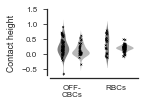

In [31]:
plt.figure(figsize=(4/2.54,3/2.54))
sns.set(context="paper",style='white',font='Arial',rc={"xtick.major.size": 0, "ytick.major.size": 4,"lines.markeredgewidth": 0.02,"lines.markersize":10})
ax = sns.violinplot(x="group",y="min_height", data=cc_plots,hue='class',hue_order=[0,1],order=['off','rbc'],orient="v",inner=None,\
                    linewidth=0,palette=sns.light_palette('gray',n_colors=3,reverse=True))
ax2=sns.stripplot(x="group", y="min_height", data=cc_plots, hue='class',hue_order=[0,1],order=['off','rbc'],jitter=0.05,split=True, marker='x',size=2,linewidth=0.5,palette=['black','black'])
ax.set(xlabel='',xticklabels=['OFF-\nCBCs','RBCs'],ylim=(-0.7,1.5))
plt.legend([])
ax.set_ylabel('Contact height')
sns.despine(offset=3)
# plt.savefig('figures/cc_stats_min_height.svg',bbox_inches='tight',dpi=300)
plt.show()

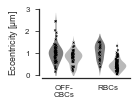

In [32]:
plt.figure(figsize=(4/2.54,3/2.54))
sns.set(context="paper",style='white',font='Arial',rc={"xtick.major.size": 0, "ytick.major.size": 4,"lines.markeredgewidth": 0.02,"lines.markersize":10})
ax = sns.violinplot(x="group",y="excentricity", data=cc_plots,hue='class',hue_order=[0,1],order=['off','rbc'],orient="v",inner=None,\
                    linewidth=0,palette=sns.light_palette('gray',n_colors=3,reverse=True))
ax = sns.stripplot(x="group", y="excentricity", data=cc_plots, hue='class',hue_order=[0,1],order=['off','rbc'],jitter=0.05,split=True,\
                   size=2,marker='x',linewidth=0.5,palette=['black','black'])
ax.set(xlabel='',xticklabels=['OFF-\nCBCs','RBCs'],ylim=(0,3),yticks=[0,1,2,3])
plt.legend([])
ax.set_ylabel('Eccentricity [$\mu m$]')
sns.despine(offset=3)
# plt.savefig('figures/cc_stats_eccentricity_min.svg',bbox_inches='tight',dpi=300)
plt.show()

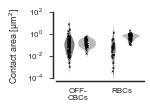

In [33]:
plt.figure(figsize=(4/2.54,3/2.54))
sns.set(context="paper",style='white',font='Arial',rc={"xtick.major.size": 0, "ytick.major.size": 4,"lines.markeredgewidth": 0.02,"lines.markersize":10})
ax = sns.stripplot(x="group", y="area", data=cc_plots, hue='class',hue_order=[0,1],order=['off','rbc'],jitter=0, size=0,marker='x',palette=['black','black'])
plt.legend([],loc='upper left')
ax2 = ax.twinx()
sns.violinplot(x="group",y="area_log", data=cc_plots,hue='class',hue_order=[0,1],order=['off','rbc'],orient="v",inner=None,linewidth=0,palette=sns.light_palette('gray',n_colors=3,reverse=True),ax=ax2)
sns.stripplot(x="group", y="area_log", data=cc_plots, hue='class',hue_order=[0,1],order=['off','rbc'],jitter=0.05,split=True,size=2,marker='x',linewidth=0.5,palette=['black','black',],ax=ax2)
ax.set(yscale='log',ylim=(1e-4,1e2),xlabel='',xticklabels=['OFF-\nCBCs','RBCs'],ylabel='Contact area [$\mu m^2$]')
ax.set_yticks([1e-4,1e-2,1,1e2])
ax2.set(ylim=(-4,2),ylabel='',yticks=[])
sns.despine(offset=3)
plt.legend([])
# plt.savefig('figures/cc_stats_area.svg',bbox_inches='tight',dpi=300)
plt.show()

### Testing classification methods

In [34]:
for gamma in np.logspace(-4,-1,4):
    for C in np.logspace(0,6,7):
        loo=cross_validation.LeaveOneOut(cc_log_norm_off.shape[0])
        clf_svm=svm.SVC(gamma=gamma,C=C)
        scores_svm_loo = cross_validation.cross_val_score(clf_svm,cc_log_norm_off.ix[:,5:].as_matrix(),\
                                                          cc_log_norm_off['class'].as_matrix(),cv=loo)
        prediction_svm_loo = cross_validation.cross_val_predict(clf_svm,cc_log_norm_off.ix[:,5:].as_matrix(),\
                                                                cc_log_norm_off['class'].as_matrix(),cv=loo)
        print(gamma,C,np.mean(scores_svm_loo),\
              np.sum(prediction_svm_loo>cc_log_norm_off['class'].as_matrix())/np.sum(cc_log_norm_off['class'].as_matrix()==0)\
              ,np.sum(prediction_svm_loo<cc_log_norm_off['class'].as_matrix())/np.sum(cc_log_norm_off['class'].as_matrix()==1))

0.0001 1.0 0.6125 0.0 1.0
0.0001 10.0 0.6125 0.0 1.0
0.0001 100.0 0.6375 0.0 0.935483870968
0.0001 1000.0 0.7875 0.183673469388 0.258064516129
0.0001 10000.0 0.7125 0.224489795918 0.387096774194
0.0001 100000.0 0.6875 0.265306122449 0.387096774194
0.0001 1000000.0 0.725 0.224489795918 0.354838709677
0.001 1.0 0.6125 0.0 1.0
0.001 10.0 0.6375 0.0 0.935483870968
0.001 100.0 0.8 0.183673469388 0.225806451613
0.001 1000.0 0.7 0.224489795918 0.41935483871
0.001 10000.0 0.7375 0.204081632653 0.354838709677
0.001 100000.0 0.725 0.244897959184 0.322580645161
0.001 1000000.0 0.675 0.30612244898 0.354838709677
0.01 1.0 0.6375 0.0 0.935483870968
0.01 10.0 0.7375 0.244897959184 0.290322580645
0.01 100.0 0.725 0.224489795918 0.354838709677
0.01 1000.0 0.7375 0.224489795918 0.322580645161
0.01 10000.0 0.6875 0.30612244898 0.322580645161
0.01 100000.0 0.6625 0.30612244898 0.387096774194
0.01 1000000.0 0.6625 0.30612244898 0.387096774194
0.1 1.0 0.7625 0.204081632653 0.290322580645
0.1 10.0 0.725 0.26

In [35]:
for gamma in np.logspace(-4,0,5):
    for C in np.logspace(0,5,6):
        loo=cross_validation.LeaveOneOut(cc_log_norm.ix[cc_log_norm['group']=='rbc',:].shape[0])
        clf_svm=svm.SVC(gamma=gamma,C=C)
        scores_svm_loo = cross_validation.cross_val_score(clf_svm,cc_log_norm.ix[cc_log_norm['group']=='rbc',5:].as_matrix(),\
                                                          cc_log_norm.ix[cc_log_norm['group']=='rbc']['class'].as_matrix(),cv=loo)
        prediction_svm_loo = cross_validation.cross_val_predict(clf_svm,cc_log_norm.ix[cc_log_norm['group']=='rbc',5:].as_matrix(),\
                                                                cc_log_norm.ix[cc_log_norm['group']=='rbc']['class'].as_matrix(),cv=loo)
        print(gamma,C,np.mean(scores_svm_loo),\
              np.sum(prediction_svm_loo>cc_log_norm.ix[cc_log_norm['group']=='rbc']['class'].as_matrix())/np.sum(cc_log_norm.ix[cc_log_norm['group']=='rbc']['class'].as_matrix()==0),\
              np.sum(prediction_svm_loo<cc_log_norm.ix[cc_log_norm['group']=='rbc']['class'].as_matrix())/np.sum(cc_log_norm.ix[cc_log_norm['group']=='rbc']['class'].as_matrix()==1))

0.0001 1.0 0.787878787879 1.0 0.0
0.0001 10.0 0.787878787879 1.0 0.0
0.0001 100.0 0.878787878788 0.571428571429 0.0
0.0001 1000.0 0.939393939394 0.238095238095 0.0128205128205
0.0001 10000.0 0.949494949495 0.142857142857 0.025641025641
0.0001 100000.0 0.949494949495 0.190476190476 0.0128205128205
0.001 1.0 0.787878787879 1.0 0.0
0.001 10.0 0.878787878788 0.571428571429 0.0
0.001 100.0 0.939393939394 0.238095238095 0.0128205128205
0.001 1000.0 0.949494949495 0.142857142857 0.025641025641
0.001 10000.0 0.949494949495 0.190476190476 0.0128205128205
0.001 100000.0 0.939393939394 0.142857142857 0.0384615384615
0.01 1.0 0.878787878788 0.571428571429 0.0
0.01 10.0 0.949494949495 0.190476190476 0.0128205128205
0.01 100.0 0.939393939394 0.190476190476 0.025641025641
0.01 1000.0 0.919191919192 0.190476190476 0.0512820512821
0.01 10000.0 0.949494949495 0.142857142857 0.025641025641
0.01 100000.0 0.949494949495 0.142857142857 0.025641025641
0.1 1.0 0.929292929293 0.238095238095 0.025641025641
0.1 

In [36]:
off_svm_cv=svm.SVC(gamma=1e-3,C=100)
rbc_svm_cv=svm.SVC(gamma=1e-1,C=10)
loo=cross_validation.LeaveOneOut(cc_log_norm_off.shape[0])
off_scores_svm_cv = cross_validation.cross_val_score(off_svm_cv,cc_log_norm_off.ix[:,5:].as_matrix(),\
                                                        cc_log_norm_off['class'].as_matrix(),cv=loo)
off_prediction_cv = cross_validation.cross_val_predict(off_svm_cv,cc_log_norm_off.ix[:,5:].as_matrix(),\
                                                        cc_log_norm_off['class'].as_matrix(),cv=loo)
loo=cross_validation.LeaveOneOut(cc_log_norm.ix[cc_log_norm['group']=='rbc',:].shape[0])
rbc_scores_svm_cv = cross_validation.cross_val_score(rbc_svm_cv,cc_log_norm.ix[cc_log_norm['group']=='rbc',5:].as_matrix(),\
                                                        cc_log_norm.ix[cc_log_norm['group']=='rbc']['class'].as_matrix(),cv=loo)
rbc_prediction_cv = cross_validation.cross_val_predict(rbc_svm_cv,cc_log_norm.ix[cc_log_norm['group']=='rbc',5:].as_matrix(),\
                                                        cc_log_norm.ix[cc_log_norm['group']=='rbc']['class'].as_matrix(),cv=loo)

In [37]:
rbc_cv_plot=classified_contacts[classified_contacts['group']=='rbc'].copy().reset_index().drop('index',axis=1)
rbc_cv_plot.loc[:,'prediction']=rbc_prediction_cv
off_cv_plot=classified_contacts_off.copy()
off_cv_plot.loc[:,'prediction']=off_prediction_cv

In [38]:
cc_cv_plot=pd.concat((off_cv_plot[['cell','rod','type','class','group','prediction']],rbc_cv_plot[['cell','rod','type','class','group','prediction']]))
cc_cv_plot.loc[:,'error']=np.abs(cc_cv_plot['class']-cc_cv_plot['prediction'])

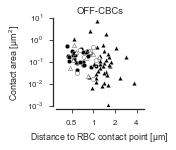

In [39]:
plt.figure(figsize=(4/2.54,4/2.54))
sns.set(font='Arial',style='white',context='paper',rc={"xtick.major.size": 4, "ytick.major.size": 4})
ax=plt.scatter(off_cv_plot[(off_cv_plot['class']==1)&(off_cv_plot['prediction']==1)]['rbc_contact_dist'],\
               off_cv_plot[(off_cv_plot['class']==1)&(off_cv_plot['prediction']==1)]['area'],marker='o',c='k',s=20,lw=0.3,edgecolor='w').axes
plt.scatter(off_cv_plot[(off_cv_plot['class']==0)&(off_cv_plot['prediction']==0)]['rbc_contact_dist'],\
               off_cv_plot[(off_cv_plot['class']==0)&(off_cv_plot['prediction']==0)]['area'],marker='^',c='k',s=20,lw=0.3,edgecolor='w')
plt.scatter(off_cv_plot[(off_cv_plot['class']==1)&(off_cv_plot['prediction']==0)]['rbc_contact_dist'],\
               off_cv_plot[(off_cv_plot['class']==1)&(off_cv_plot['prediction']==0)]['area'],marker='o',c='w',s=17,lw=0.3)
plt.scatter(off_cv_plot[(off_cv_plot['class']==0)&(off_cv_plot['prediction']==1)]['rbc_contact_dist'],\
               off_cv_plot[(off_cv_plot['class']==0)&(off_cv_plot['prediction']==1)]['area'],marker='^',c='w',s=17,lw=0.3)
ax.set(xscale='log',xlim=(3e-1,5e0),yscale='log',ylim=(1e-3,1e1))
ax.set(xticks=[5e-1,1e0,2e0,4e0])
ax.set_xticklabels([0.5,1,2,4])
plt.title('OFF-CBCs')
ax.set_xlabel('Distance to RBC contact point [$\mu m$]')
ax.set_ylabel('Contact area [$\mu m^2$]')
sns.despine(offset=3)
# plt.savefig('figures/classification_rod_off.svg',bbox_inches='tight',dpi=300,transparent=True)
plt.show()

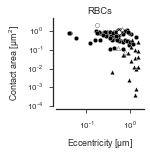

In [40]:
plt.figure(figsize=(4/2.54,4/2.54))
sns.set(font='Arial',style='white',context='paper',rc={"xtick.major.size": 4, "ytick.major.size": 4})
ax=plt.scatter(rbc_cv_plot[(rbc_cv_plot['class']==1)&(rbc_cv_plot['prediction']==1)]['excentricity'],\
               rbc_cv_plot[(rbc_cv_plot['class']==1)&(rbc_cv_plot['prediction']==1)]['area'],marker='o',c='k',s=20,lw=0.3,edgecolor='w').axes
plt.scatter(rbc_cv_plot[(rbc_cv_plot['class']==0)&(rbc_cv_plot['prediction']==0)]['excentricity'],\
               rbc_cv_plot[(rbc_cv_plot['class']==0)&(rbc_cv_plot['prediction']==0)]['area'],marker='^',c='k',s=20,lw=0.3,edgecolor='w')
plt.scatter(rbc_cv_plot[(rbc_cv_plot['class']==1)&(rbc_cv_plot['prediction']==0)]['excentricity'],\
               rbc_cv_plot[(rbc_cv_plot['class']==1)&(rbc_cv_plot['prediction']==0)]['area'],marker='o',c='w',s=17,lw=0.3)
plt.scatter(rbc_cv_plot[(rbc_cv_plot['class']==0)&(rbc_cv_plot['prediction']==1)]['excentricity'],\
               rbc_cv_plot[(rbc_cv_plot['class']==0)&(rbc_cv_plot['prediction']==1)]['area'],marker='^',c='w',s=17,lw=0.3)
ax.set(xscale='log',xlim=(2e-2,2e0),yscale='log',ylim=(1e-4,5e0))
plt.title('RBCs')
ax.set_xlabel('Eccentricity [$\mu m$]')
ax.set_ylabel('Contact area [$\mu m^2$]')
sns.despine(offset=3)
# plt.savefig('figures/classification_rod_rbc.svg',bbox_inches='tight',dpi=300,transparent=True)
plt.show()

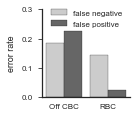

In [41]:
plt.figure(figsize=(4/2.54,4/2.54))
sns.set(font='Arial',context='paper',style='white',rc={"xtick.major.size": 0, "ytick.major.size": 4})
ax=sns.barplot(x='group',y='error',hue='class',data=cc_cv_plot,ci=None,palette=[np.array([0.8,0.8,0.8,1.]),np.array([0.4,0.4,0.4,1.])])
ax.set(ylabel='error rate',xlabel='',xticklabels=['Off CBC','RBC'],yticks=[0,0.1,0.2,0.3])
plt.legend(bbox_to_anchor=(1, 1.08),labels=['false negative','false positive'])
sns.despine()
# plt.savefig('figures/classication_performance_rods.svg',bbox_inches='tight',dpi=300,transparent=True)
plt.show()

In [42]:
clf_svm_rbc=svm.SVC(gamma=1e-1,C=10)
clf_svm_rbc.fit(cc_log_norm.ix[cc_log_norm['group']=='rbc',5:].as_matrix(),cc_log_norm.ix[cc_log_norm['group']=='rbc']['class'].as_matrix())

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [43]:
contact_summary.loc[:,'prediction']=0
contact_summary.ix[contact_summary['group']=='rbc','prediction']=clf_svm_rbc.predict(contact_summary_log_norm.ix[contact_summary_log_norm['group']=='rbc',4:11])

In [44]:
clf_svm_off=svm.SVC(gamma=1e-3,C=100)
clf_svm_off.fit(cc_log_norm_off.ix[:,5:].as_matrix(),cc_log_norm_off['class'].as_matrix())
contact_summary.ix[contact_summary['group']=='off','prediction']=clf_svm_off.predict(contact_summary_log_norm_off.ix[:,4:].as_matrix())

In [45]:
# contact_summary.to_pickle('data/rod_contact_predictions')